<a href="https://colab.research.google.com/github/yiruchen4/Chen2025/blob/main/Code/ChenFigure5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from scipy.stats import friedmanchisquare, wilcoxon
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import MaxNLocator
from IPython.display import Image
import warnings

warnings.filterwarnings("ignore")

def add_sig_line(ax, x1, x2, y, p_val):
  if   p_val < 1e-4: stars = '****'
  elif p_val < 1e-3: stars = '***'
  elif p_val < 1e-2: stars = '**'
  elif p_val < 5e-2: stars = '*'
  else: return
  ax.plot([x1, x2], [y + y_offset, y + y_offset], lw=1.5, c='gray')
  ax.text((x1 + x2) / 2, y + y_offset - (y_offset * 0.35), stars,
          ha='center', va='bottom', fontsize=14, fontweight='bold')
def holm_bonferroni(pvals):
  pvals = np.asarray(pvals, dtype=float)
  m = len(pvals)
  order = np.argsort(pvals)                # ascending
  sorted_p = pvals[order]
  adj_sorted = np.minimum(sorted_p * (m - np.arange(m)), 1.0)
  # enforce monotonicity
  for i in range(1, m):
      if adj_sorted[i] < adj_sorted[i-1]:
          adj_sorted[i] = adj_sorted[i-1]
  adjusted = np.empty_like(pvals)
  adjusted[order] = adj_sorted
  return adjusted

In [2]:
# @title Figure 5A
Image(url='https://github.com/yiruchen4/Chen2025/blob/main/Images/Figure%204A.png?raw=true', width=1000)

Friedman test p-value: 0.04979
Seeking
Wilcoxon saline vs SCH23390: T = 13.0, p (Holm) = 2.13e-02 (raw p = 1.304e-02)
Wilcoxon saline vs haloperidol: T = 6.5, p (Holm) = 2.13e-02 (raw p = 1.064e-02)
Friedman test p-value: 0.11916
Exploring
Wilcoxon saline vs SCH23390: T = 31.0, p (Holm) = 3.10e-01 (raw p = 3.100e-01)
Wilcoxon saline vs haloperidol: T = 22.0, p (Holm) = 1.08e-01 (raw p = 5.421e-02)
Friedman test p-value: 0.00728
Activity
Wilcoxon saline vs SCH23390: T = 39.0, p (Holm) = 6.85e-01 (raw p = 6.848e-01)
Wilcoxon saline vs haloperidol: T = 0.0, p (Holm) = 4.88e-04 (raw p = 2.441e-04)
Friedman test p-value: 0.00439
Feeding
Wilcoxon saline vs SCH23390: T = 38.0, p (Holm) = 3.91e-01 (raw p = 3.910e-01)
Wilcoxon saline vs haloperidol: T = 3.0, p (Holm) = 1.22e-03 (raw p = 6.104e-04)


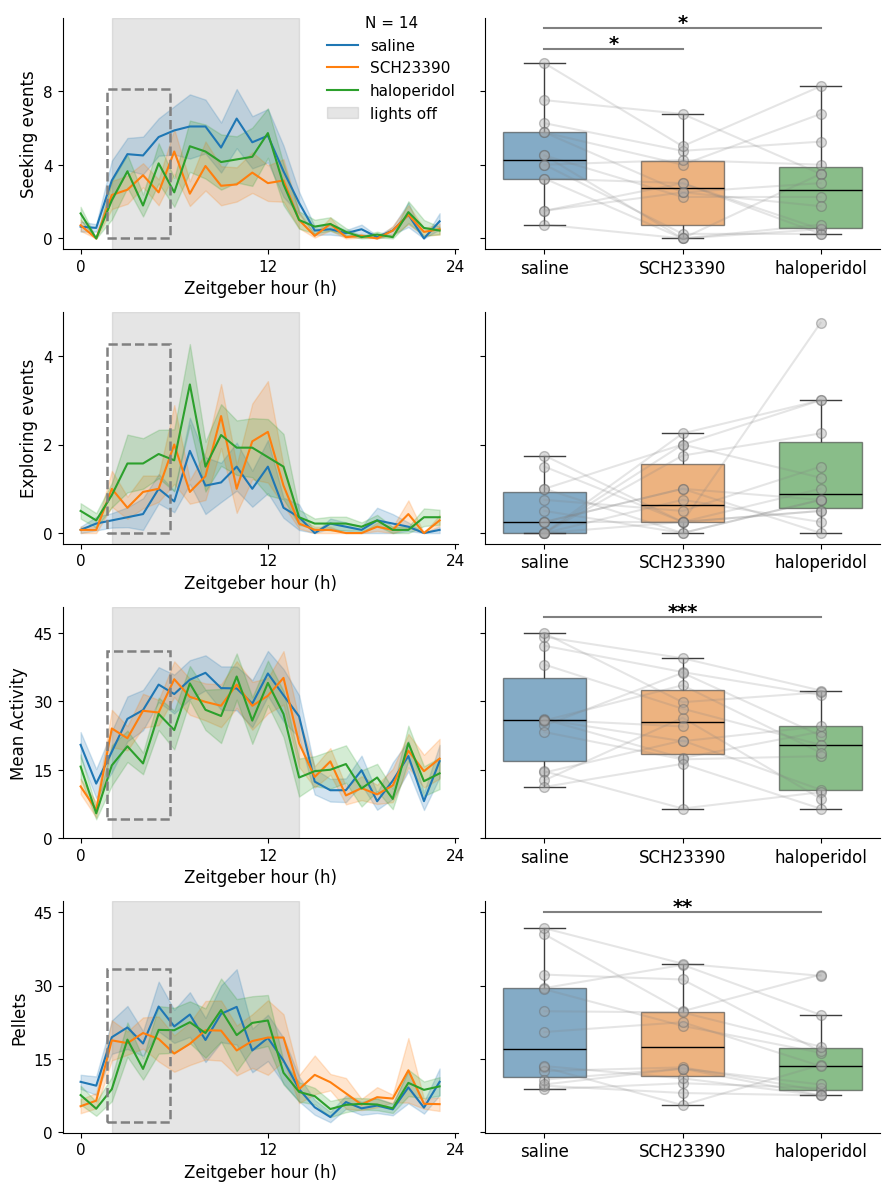

In [3]:
# @title Figure 5B-E
# Colors
default_palette = sns.color_palette()
treatment_color_map = {
    'saline': default_palette[0],        # blue
    'SCH23390': default_palette[1],      # orange
    'haloperidol': default_palette[2]    # green
}

# Load CSVs
df_activity  = pd.read_csv(r"https://raw.githubusercontent.com/yiruchen4/Chen2025/main/Data/data_Figure5_d.csv")
df_seeking   = pd.read_csv(r"https://raw.githubusercontent.com/yiruchen4/Chen2025/main/Data/data_Figure5_b.csv")
df_exploring = pd.read_csv(r"https://raw.githubusercontent.com/yiruchen4/Chen2025/main/Data/data_Figure5_c.csv")
df_feeding   = pd.read_csv(r"https://raw.githubusercontent.com/yiruchen4/Chen2025/main/Data/data_Figure5_e.csv")

raw_dfs = {
    'seeking': df_seeking,
    'exploring': df_exploring,
    'activity': df_activity,
    'feeding': df_feeding
}
titles = ['Seeking','Exploring','Activity','Feeding']
metrics_order = ['seeking','exploring','activity','feeding']  # ensures order matches titles
treatment_order = ['saline', 'SCH23390', 'haloperidol']

# Plot
fig, axes = plt.subplots(4, 2, figsize=(9, 12), sharey='row')

for col_idx, (metric, title) in enumerate(zip(metrics_order, titles)):
    df = raw_dfs[metric]

    # Filter: zthour 2–5
    filtered_df = df[(df['zthour'] >= 2) & (df['zthour'] <= 5)]

    # Top row: line plot
    ax_top = axes[col_idx, 0]
    if metric == 'activity':
        y_col = 'activity'
    elif metric == 'feeding':
        y_col = 'pellets'
    else:
        y_col = 'event'

    sns.lineplot(
        data=df, x='zthour', y=y_col, hue='treatment',
        errorbar='se', ax=ax_top, palette=treatment_color_map
    )

    # Highlight window (2–5 ZT) with dashed rectangle
    grouped_line = df.groupby(['zthour', 'treatment'])[y_col].agg(['mean', 'sem']).reset_index()
    grouped_line['lower'] = grouped_line['mean'] - grouped_line['sem']
    grouped_line['upper'] = grouped_line['mean'] + grouped_line['sem']
    y_min = grouped_line['lower'].min()
    y_max = grouped_line['upper'].max()
    highlight_box = patches.Rectangle(
        (1.7, y_min), 4, y_max - y_min, linewidth=1.8,
        edgecolor='gray', linestyle='--', facecolor='none', zorder=2
    )
    ax_top.add_patch(highlight_box)

    # Dark phase shading
    ax_top.axvspan(2, 14, color='gray', alpha=0.2, zorder=0, label='lights off')
    ax_top.set_xlabel('Zeitgeber hour (h)', fontsize=12)
    ax_top.set_xticks([0, 12, 24])
    ax_top.set_xticklabels(['0', '12', '24'], fontsize=11)
    ax_top.yaxis.set_major_locator(MaxNLocator(nbins=4, integer=True))
    ax_top.tick_params(axis='y', labelsize=11)
    ax_top.tick_params(axis='x', labelsize=11)
    if col_idx == 0:
        n_subjects = len(filtered_df["device_number"].unique())
        ax_top.legend(title=f'N = {n_subjects}', title_fontsize=11,
                      loc='upper right', bbox_to_anchor=(1.03, 1.07),
                      frameon=False, fontsize=11)
    else:
        ax_top.get_legend().remove()

    # Bottom row: summary box + strip + stats
    ax_bot = axes[col_idx, 1]
    if metric == 'activity':
        grouped = filtered_df.groupby(['device_number', 'treatment', 'sex'])['activity'].mean().reset_index(name='value')
        ylabel = "Mean Activity"
    elif metric == 'feeding':
        grouped = filtered_df.groupby(['device_number', 'treatment', 'sex'])['pellets'].mean().reset_index(name='value')
        ylabel = "Pellets"
    else:
        grouped = filtered_df.groupby(['device_number', 'treatment', 'sex'])['event'].mean().reset_index(name='value')
        ylabel = f"{metric.capitalize()} events"

    grouped['treatment'] = pd.Categorical(grouped['treatment'], categories=treatment_order, ordered=True)

    # Box plot
    palette = [treatment_color_map[t] for t in treatment_order]
    sns.boxplot(
        data=grouped, x='treatment', y='value', palette=palette, ax=ax_bot,
        width=0.6, showcaps=True, boxprops=dict(alpha=0.6),
        medianprops=dict(color='black'), showfliers=False
    )

    # Strip plot
    sns.stripplot(
        data=grouped, x='treatment', y='value', dodge=False, jitter=False, size=7,
        marker='o', alpha=0.4, color='darkgray', linewidth=1, ax=ax_bot
    )

    # Ensure box faces match our palette (and keep borders)
    for patch, treatment in zip(ax_bot.artists, treatment_order):
        patch.set_facecolor(treatment_color_map[treatment])
        patch.set_edgecolor('black')
        patch.set_alpha(0.6)

    # Connect paired points
    for device_id, sub in grouped.groupby('device_number'):
        sorted_sub = sub.sort_values('treatment')
        ax_bot.plot(sorted_sub['treatment'], sorted_sub['value'], linestyle='-', alpha=0.2, color='gray')

    ax_bot.set_xlabel('')
    ax_bot.set_ylabel(ylabel, fontsize=12)
    ax_top.set_ylabel(ylabel, fontsize=12)
    ax_bot.yaxis.set_major_locator(MaxNLocator(nbins=4, integer=True))
    ax_bot.tick_params(axis='y', labelsize=11)
    ax_bot.tick_params(axis='x', labelsize=12)

    # Friedman + Wilcoxon (Holm–Bonferroni)
    anova_df = grouped.pivot(index='device_number', columns='treatment', values='value').dropna()
    if all(t in anova_df.columns for t in treatment_order):
        stat, p = friedmanchisquare(anova_df['saline'], anova_df['SCH23390'], anova_df['haloperidol'])
        print(f'Friedman test p-value: {p:.5f}')

        pairs = [('saline', 'SCH23390'), ('saline', 'haloperidol')]
        results = []
        for a, b in pairs:
            res = wilcoxon(anova_df[a], anova_df[b])
            results.append({'pair': (a, b), 'stat': res.statistic, 'p_raw': res.pvalue})

        p_raws = [r['p_raw'] for r in results]
        p_adj  = holm_bonferroni(p_raws)
        alpha = 0.05

        print(title)
        for r, pA in zip(results, p_adj):
            a, b = r['pair']
            print(f"Wilcoxon {a} vs {b}: T = {r['stat']}, p (Holm) = {pA:.2e} (raw p = {r['p_raw']:.3e})")

        # Annotation helpers
        y_max = grouped['value'].max()
        y_offset = y_max * 0.06
        base_y = y_max * 1.02

        x_map = {'saline': 0, 'SCH23390': 1, 'haloperidol': 2}
        for (a, b), pA in zip([r['pair'] for r in results], p_adj):
            if pA < alpha:
                add_sig_line(ax_bot, x_map[a], x_map[b], base_y, pA)
                base_y += y_offset * 2

    # Keep zero in view if needed
    y = ax_bot.get_ylim()
    ax_bot.set_ylim([min(y[0], 0), y[1]])

sns.despine()
plt.tight_layout()
plt.show()